Problem 1

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

In [2]:
# specify parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
size_z = 9 
betafirm = (1 / (1 + r))
mu_z = 1

In [3]:
#Specify k grid size 

dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (mu_z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

In [4]:
#Draw z values

import ar1_approx as ar1

# set our parameters

rho = 0.7605
mu = 0.0
sigma_eps = 0.213
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))

In [5]:
#Ada-Cooper Method

# import packages
from scipy.stats import norm

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu

# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)

# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
# print('Transition matrix = ', pi)
# print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))

Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [6]:
#Exponentiate zvec

zvec = np.exp(z_grid)

In [7]:
# operating profits, op
op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) 

#Take zvec and make it to the power of 1/1-alphal 
zvec_for_op = zvec ** (1 / (1 - alpha_l))
zvec_for_op = zvec_for_op.reshape(1,9)
            
# firm cash flow, e
e = np.zeros((size_z, sizek, sizek))

for i in range(sizek):
    for j in range(sizek):
        for h in range(size_z):
            e[h, i, j] = (op[i] * zvec_for_op[0,h] - kvec[j] + ((1 - delta) * kvec[i]) -
                       ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2) / kvec[i]))

In [16]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
#Expected Value function for every choice of capital today & tmr, and shock today 
V = np.zeros((size_z, sizek)) # initial guess at value function, for any amount of capital, the value of that is 0 - starting pt
Vmat = np.zeros((size_z, sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()
PF = np.zeros((size_z, sizek))

while  VFdist > VFtol and VFiter < VFmaxiter: 
    TV = np.copy(V)
    print("Iteration Number:", VFiter)
    for h in range(size_z): #loop over z 
        #Finding expected value of V(z',k') given z and transition probabilities
        weights = pi[h]
        Vave = np.average(Vmat, axis = 0, weights = weights)
        Vmax = Vave.max(axis=1)
        V[h] = Vmax.T
        PFmax = np.argmax(Vave, axis=1)  # find the index of the optimal k'
        PF [h] = PFmax.T
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k prime
                for g in range(size_z): #loop over z prime
                    Vmat[g, i, j] = e[g, i, j] + betafirm * V[g][j]
        
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    VFiter += 1
    
VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter - 1 )
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V  # solution to the functional equation

Iteration Number: 1
Iteration Number: 2
Iteration Number: 3
Iteration Number: 4
Iteration Number: 5
Iteration Number: 6
Iteration Number: 7
Iteration Number: 8
Iteration Number: 9
Iteration Number: 10
Iteration Number: 11
Iteration Number: 12
Iteration Number: 13
Iteration Number: 14
Iteration Number: 15
Iteration Number: 16
Iteration Number: 17
Iteration Number: 18
Iteration Number: 19
Iteration Number: 20
Iteration Number: 21
Iteration Number: 22
Iteration Number: 23
Iteration Number: 24
Iteration Number: 25
Iteration Number: 26
Iteration Number: 27
Iteration Number: 28
Iteration Number: 29
Iteration Number: 30
Iteration Number: 31
Iteration Number: 32
Iteration Number: 33
Iteration Number: 34
Iteration Number: 35
Iteration Number: 36
Iteration Number: 37
Iteration Number: 38
Iteration Number: 39
Iteration Number: 40
Iteration Number: 41
Iteration Number: 42
Iteration Number: 43
Iteration Number: 44
Iteration Number: 45
Iteration Number: 46
Iteration Number: 47
Iteration Number: 48
I

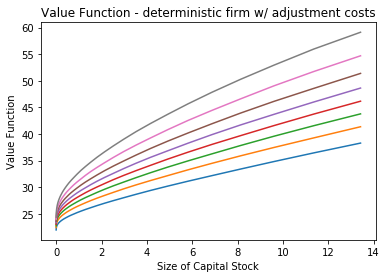

In [18]:
for i in range (0, 8):
    plt.plot(kvec,V[i])
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

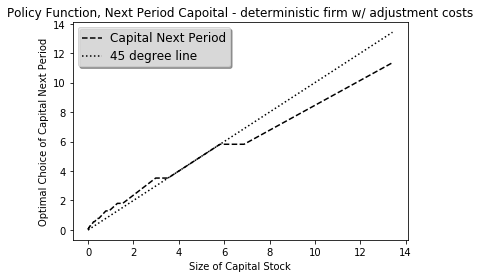

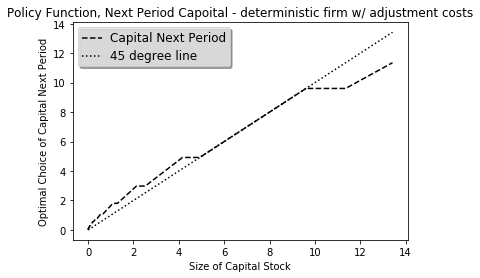

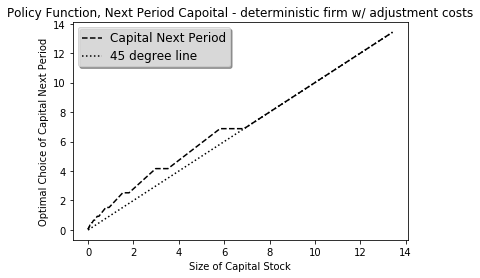

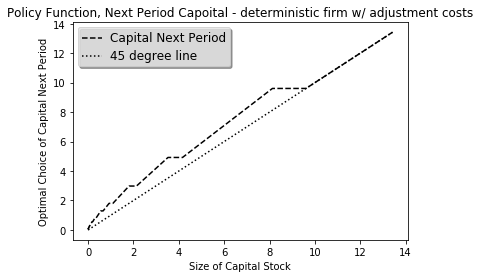

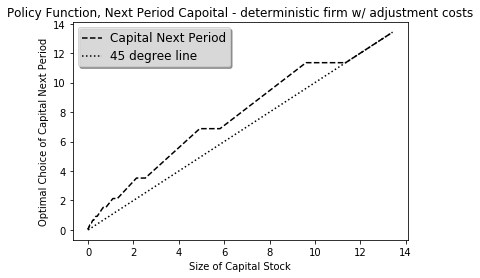

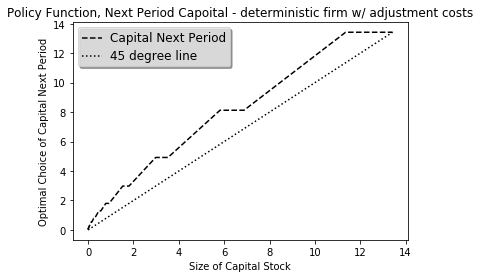

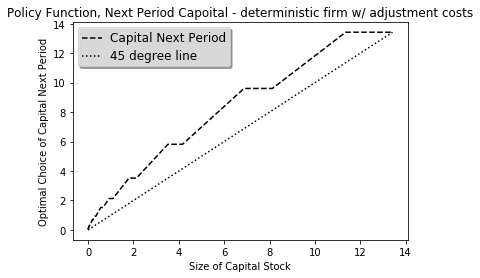

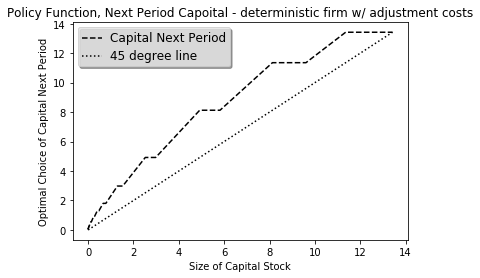

In [19]:
PF_int = PF.astype(int, copy = True)

for i in range (0, 8):
    PF1 = PF_int[i]
    optK = kvec[PF1]
    # Plot optimal capital stock rule as a function of firm size
    fig, ax = plt.subplots()
    ax.plot(kvec, optK, 'k--', label='Capital Next Period')
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

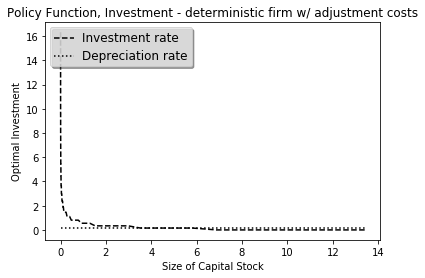

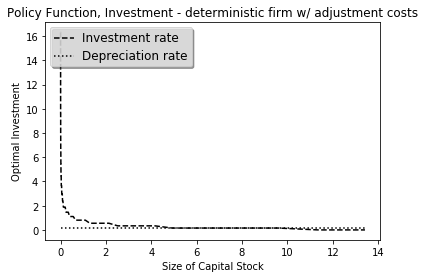

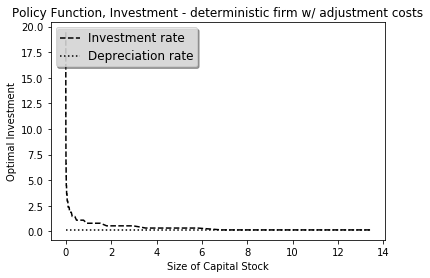

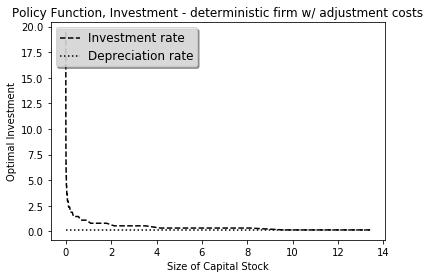

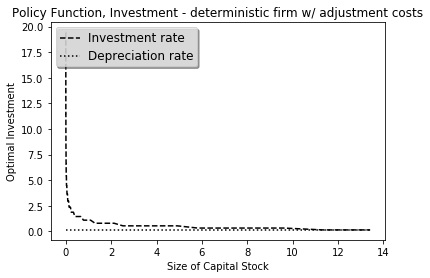

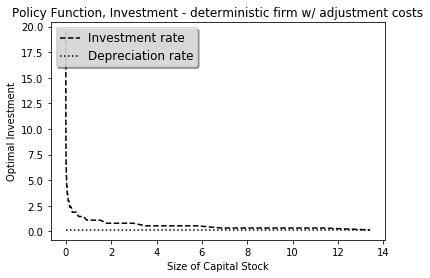

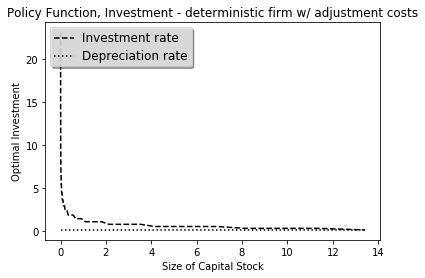

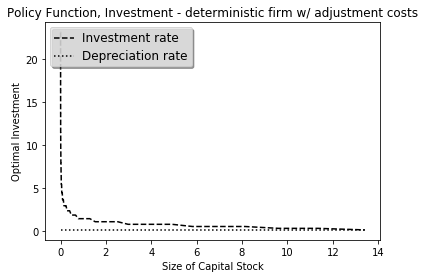

In [11]:
for i in range (0, 8):
    PF1 = PF_int[i]
    optK = kvec[PF1]
    optI = optK - (1 - delta) * kvec
    # Plot investment rule as a function of firm size
    fig, ax = plt.subplots()
    ax.plot(kvec, (optI/kvec), 'k--', label='Investment rate')
    ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Investment')
    plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')
    

Problem 2

In [30]:
#We first define new cash flow functions 

psi1 = 0.03

# operating profits, op
op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kvec ** alpha_k) ** (1 / (1 - alpha_l)))) 

#Take zvec and make it to the power of 1/1-alphal 
zvec_for_op = zvec ** (1 / (1 - alpha_l))
zvec_for_op = zvec_for_op.reshape(1,9)
            
# firm cash flow, e if we invest 
e_invest = np.zeros((size_z, sizek, sizek))

for i in range(sizek):
    for j in range(sizek):
        for h in range(size_z):
            e_invest[h, i, j] = (op[i] * zvec_for_op[0,h] - kvec[j] + ((1 - delta) * kvec[i]) - 0.03 * kvec[i])
                                 
# firm cash flow, e if we do not invest 
e_noinvest = np.zeros((size_z, sizek))

for j in range(sizek):
    for h in range(size_z):
        if j == 0:
            e_noinvest[h, j] = (op[j] * zvec_for_op[0,h] - (1 - delta) * kvec[j] + ((1 - delta) * kvec[j]))
        else:
            e_noinvest[h, j] = (op[j] * zvec_for_op[0,h] - kvec[j - dens] + ((1 - delta) * kvec[j]))
            
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
#Expected Value function for every choice of capital today & tmr, and shock today 
V_invest = np.zeros((size_z, sizek)) # initial guess at value function, for any amount of capital, the value of that is 0 - starting pt
V_noinvest = np.zeros((size_z, sizek)) # initial guess at value function, for any amount of capital, the value of that is 0 - starting pt
Vmat_invest = np.zeros((size_z, sizek, sizek))  # initialize Vmat matrix
Vmat_noinvest = np.zeros((size_z, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1
start_time = time.clock()
PFB = np.zeros((size_z, sizek))
PFmax_invest = np.zeros((sizek))
V = np.zeros((size_z, sizek)) # initial guess at value function, for any amount of capital, the value of that is 0 - starting pt

while  VFdist > VFtol and VFiter < VFmaxiter:
    TV = np.copy(V)
    print("Iteration Number:", VFiter)
    for h in range(size_z): #loop over z 
        #Finding expected value of V(z',k') given z and transition probabilities
        weights = pi[h]
        Vave_invest = np.average(Vmat_invest, axis = 0, weights = weights)
        Vave_noinvest = np.average(Vmat_noinvest, axis = 0, weights = weights) #1 by 57 matrix weighted average
        Vmax_invest = Vave_invest.max(axis=1)
        PFmax_invest = np.argmax(Vave_invest, axis=1)  # find the index of the optimal k'  # find the index of the optimal k' 
        Vmax_compare = np.vstack((Vave_noinvest, Vmax_invest))
        Vmax_overall = Vmax_compare.max(axis = 0)
        
        V[h] = Vmax_overall.T
        PFB[h] = np.reshape(PFmax_invest, (1, sizek))
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k prime
                for g in range(size_z): #loop over z prime
                    Vmat_invest[g, i, j] = e_invest[g, i, j] + betafirm * V[g][j]
                    if j ==0: 
                        Vmat_noinvest[g, j]=e_noinvest[g, j] + betafirm * V[g][j]
                    else:
                        Vmat_noinvest[g, j]=e_noinvest[g, j] + betafirm * V[g][j - dens]
                    
        
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    VFiter += 1
    
VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter - 1 )
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')

VF = V  # solution to the functional equation

Iteration Number: 1
Iteration Number: 2
Iteration Number: 3
Iteration Number: 4
Iteration Number: 5
Iteration Number: 6
Iteration Number: 7
Iteration Number: 8
Iteration Number: 9
Iteration Number: 10
Iteration Number: 11
Iteration Number: 12
Iteration Number: 13
Iteration Number: 14
Iteration Number: 15
Iteration Number: 16
Iteration Number: 17
Iteration Number: 18
Iteration Number: 19
Iteration Number: 20
Iteration Number: 21
Iteration Number: 22
Iteration Number: 23
Iteration Number: 24
Iteration Number: 25
Iteration Number: 26
Iteration Number: 27
Iteration Number: 28
Iteration Number: 29
Iteration Number: 30
Iteration Number: 31
Iteration Number: 32
Iteration Number: 33
Iteration Number: 34
Iteration Number: 35
Iteration Number: 36
Iteration Number: 37
Iteration Number: 38
Iteration Number: 39
Iteration Number: 40
Iteration Number: 41
Iteration Number: 42
Iteration Number: 43
Iteration Number: 44
Iteration Number: 45
Iteration Number: 46
Iteration Number: 47
Iteration Number: 48
I

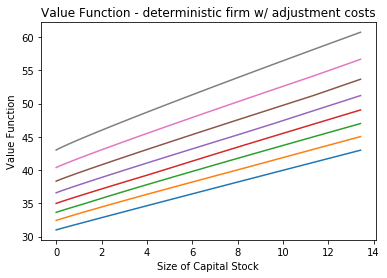

In [31]:
for i in range (0, 8):
    plt.plot(kvec,V[i])
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

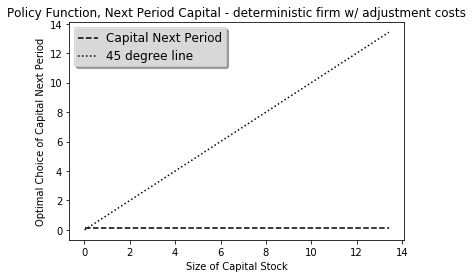

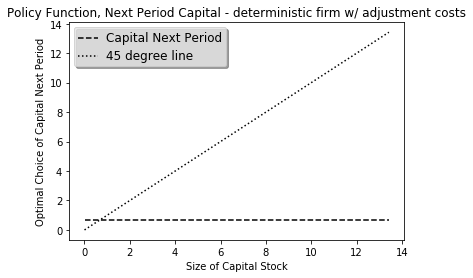

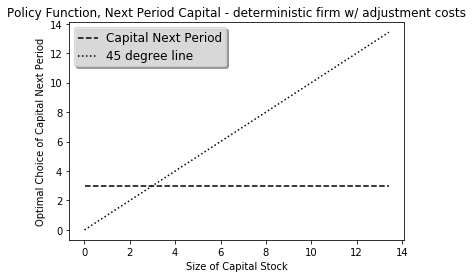

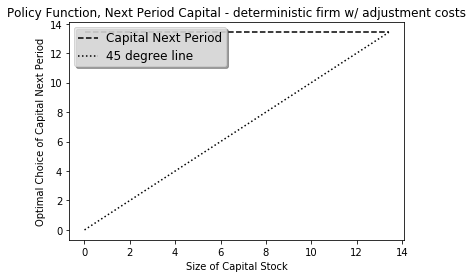

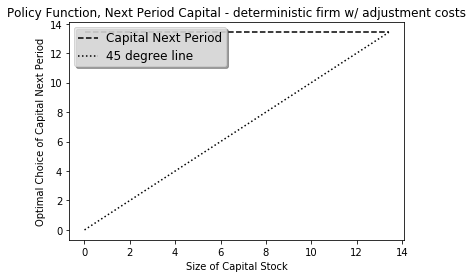

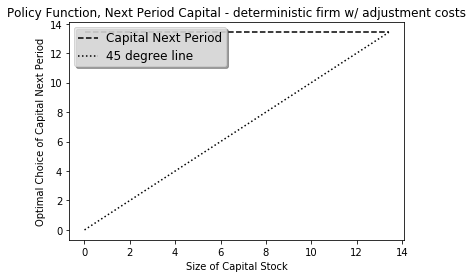

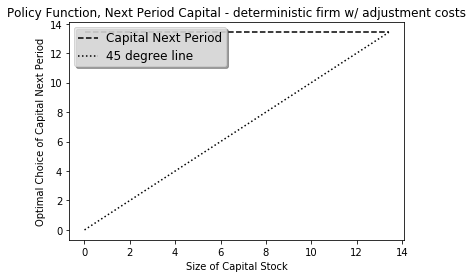

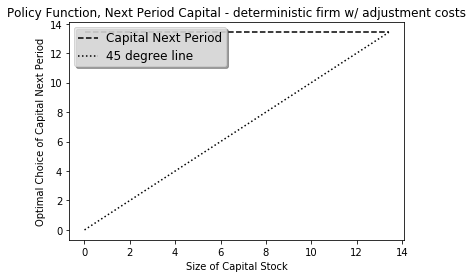

In [32]:
PFB = PFB.astype(int, copy = True)

for i in range (0, 8):
    PF1 = PFB[i]
    optK1 = kvec[PF1]
    # Plot optimal capital stock rule as a function of firm size
    fig, ax = plt.subplots()
    ax.plot(kvec, optK1, 'k--', label='Capital Next Period')
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Function, Next Period Capital - deterministic firm w/ ' +
          'adjustment costs')

Problem 3

In [8]:
params = alpha_k, alpha_l, delta, psi, w, r, betafirm

def pi2(k, z, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return alpha_k * ((alpha_l / w)) ** (alpha_l / (1 - alpha_l)) * z ** (1 / (1 - alpha_l)) * \
           k ** ((alpha_k + alpha_l - 1)/(1 - alpha_l))
    
def c2(kprime, k, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    return (psi / 2) * (2*(kprime - (1 - delta)*k)*(delta - 1)*k - (kprime - (1 - delta)*k)**2)/(k**2)


In [11]:
PFtol = 1e-6
PFdist = 7.0
PFmaxiter = 3000
PFiter = 1
start_time = time.clock()

In [14]:
from scipy.optimize import brentq

Kg = np.tile(kvec, 9)
Kg = Kg.reshape((9,57))

while PFdist > PFtol and PFiter < PFmaxiter:
    Kg_copy = np.copy(Kg) #9 x 57 matrix to store k' for every combo of k and z
    for i in range(N): #loop over z
        for j in range(sizek): #loop over k            
            def h(kprime):
                expectedpi2 = 0
                expectedc2 = 0
                for k in range(N): #loop over z'
                    g_func = lambda x: np.interp(x, kvec, Kg[k, :]) #to get k prime prime 
                    expectedpi2 += pi2(kprime, zvec[k], params) * pi[i, k]
                    expectedc2 += c2(g_func(kprime), kprime, params) * pi[i, k]
                expectedvalue = expectedpi2 + (1 - delta) - expectedc2
                c1 = psi * (kprime - (1 - delta)*kvec[j])/kvec[j]
                return 1 + c1 - (betafirm * expectedvalue)
            
            k_star = brentq(h, 1e-10, 1e5)
            Kg[i, j] = k_star
            
    PFdist = (np.absolute(Kg - Kg_copy)).max()
    PFiter += 1
        
PF_time = time.clock() - start_time
    
if PFiter < PFmaxiter:
    print('Policy function converged after this many iterations:', PFiter)
else:
    print('Policy function did not converge')

print('Coleman Policy Iteration took ', PF_time, ' seconds to solve')

Policy function converged after this many iterations: 27
Coleman Policy Iteration took  37.522087000000006  seconds to solve


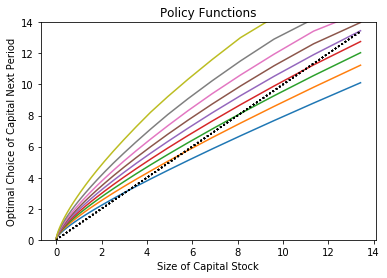

In [15]:
for i in range(9):
    plt.plot(kvec, Kg[i])
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Functions')
    plt.plot(kvec, kvec, 'k:', label='45 degree line')
    plt.ylim((0,14))
plt.show()

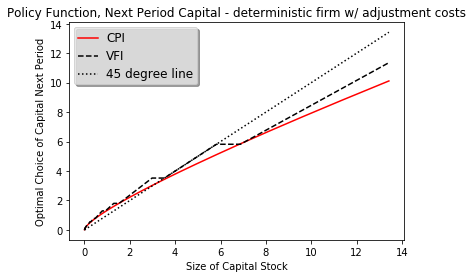

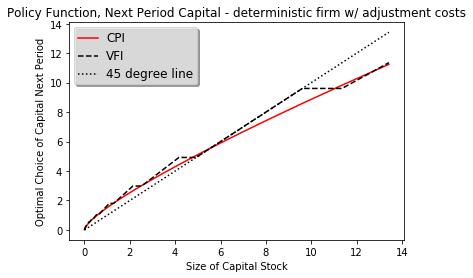

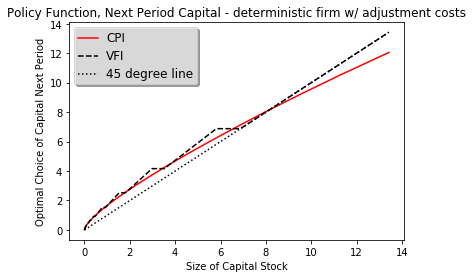

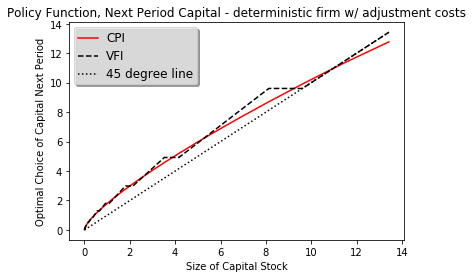

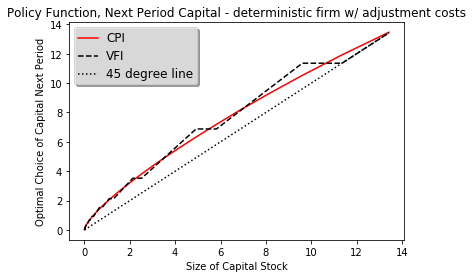

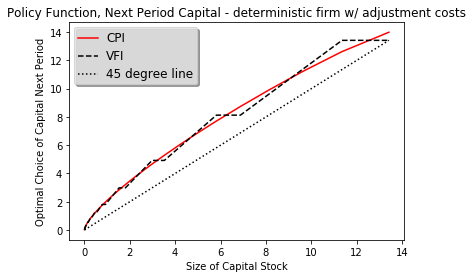

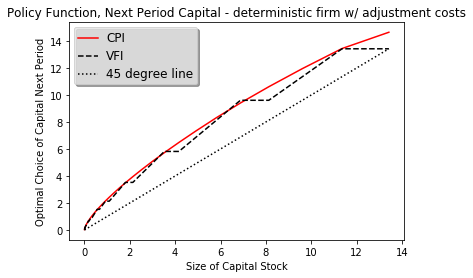

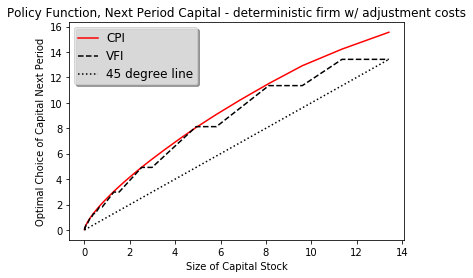

In [18]:
PF_int = PF.astype(int, copy = True)

for i in range (0, 8):
    PF1 = PF_int[i]
    optK = kvec[PF1]
    # Plot optimal capital stock rule as a function of firm size
    fig, ax = plt.subplots()
    ax.plot(kvec, Kg[i], 'r', label = 'CPI')
    ax.plot(kvec, optK, 'k--', label='VFI')
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Function, Next Period Capital - deterministic firm w/ ' +
          'adjustment costs')
    